# Quantum Elastic Wave Equation Solver
#### v1.3
*Authors: Malte Schade, Cyrill Bösch, Vaclav Hapla, Andreas Fichtner*


## 1. Importing Dependencies

In [1]:
from simulation.experiment import ForwardExperiment1D
from utility.distributions import spike, ricker, gaussian, raised_cosine, sinc, homogeneous, exponential, polynomial
from utility.plotting import plot_uv, plot_state, plot_medium, plot_heatmap, plot_multi_v1


## 2. Setting up Qiskit Runtime Service Account

In [2]:
# Set IBM Account
# from qiskit_ibm_runtime import QiskitRuntimeService
# QiskitRuntimeService.delete_account()
# QiskitRuntimeService.save_account(
#     channel='ibm_quantum',
#     instance='ibm-q/open/main',
#     token='',
#     overwrite=True
#     )
# service = QiskitRuntimeService()
# service.backends()


## 3.1. Defining Simulation Parameters

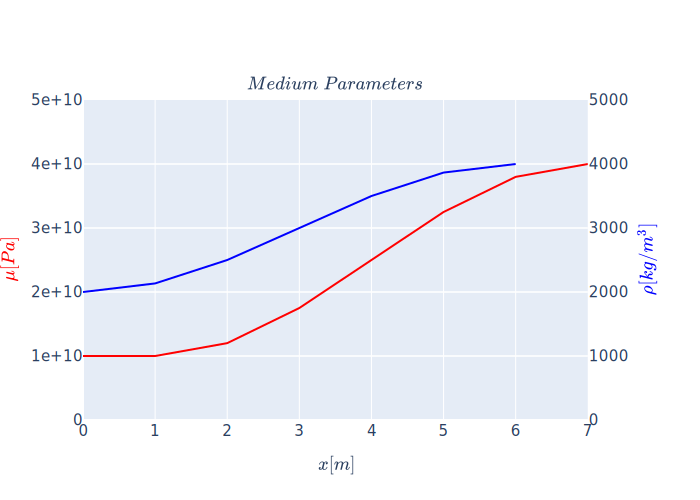

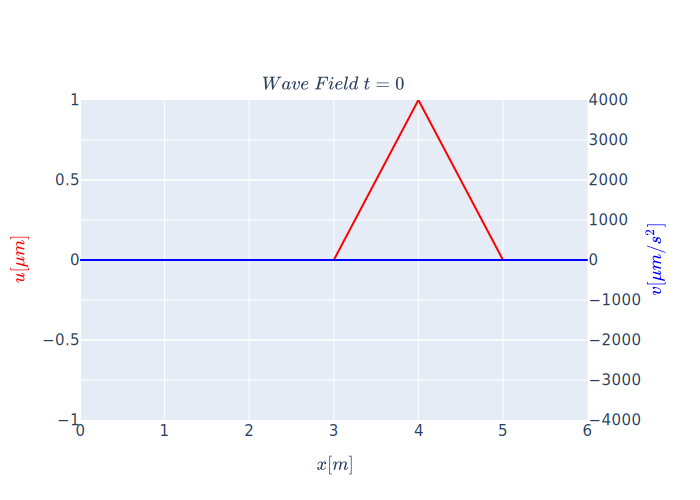

In [3]:
nx = 7
parameters = {
    'dx': 1,                                        # Grid spacing
    'nx': nx,                                       # Number of grid points
    'dt': 0.0001,                                   # Time stepping
    'nt': 10,                                       # Number of time steps
    'order': 1,                                     # Finite-difference order
    'bcs': {'left': 'DBC', 'right': 'DBC'},         # Boundary conditions
    'mu': raised_cosine(3e10, nx+1, nx, 6, 1e10),   # Elastic modulus distribution
    'rho': raised_cosine(2e3, nx, nx-1, 6, 2e3),    # Density distribution
    'u': spike(1, nx, nx//2+1),                     # Initial positions
    'v': homogeneous(0, nx),                        # Initial velocities
    'backend': {
        'synthesis': 'MatrixExponential',           # Time Evolution Synthesis Method
        'batch_size': 100,                          # Circuit Batch Size
        'fitter': 'cvxpy_gaussian',                 # State Tomography fitter
        'backend': 'ibmq_qasm_simulator',           # Cloud backend name
        'shots': 1000,                              # Number of circuit samples
        'optimization': 3,                          # Circuit optimization level
        'resilience': 1,                            # Circuit resilience level
        'seed': 0,                                  # Transpilation seed
        'local_transpilation': False,                # Local transpilation
        'method': 'statevector',                    # Classical simulation method
        'fake': None,                               # Fake backend model
        }
    }

# Plot Medium and Initial State
plot_medium(parameters['mu'], parameters['rho']).show(renderer='svg')
plot_uv(parameters['u'], parameters['v'],0, plot_v=True).show(renderer='svg')


## 3.2. Running Simulation Experiment

In [4]:
experiment = ForwardExperiment1D(verbose=2)
experiment.add_solver('ode', **parameters)
experiment.add_solver('exp', **parameters)
experiment.add_solver('local', **parameters)
experiment.add_solver('cloud', **parameters)
results = experiment.run()


2023-12-06 17:39:49,818 - INFO - Created experiment with time stamp: 20231206T173949.

2023-12-06 17:39:49,820 - INFO - Adding solver 1: ode
2023-12-06 17:39:49,821 - INFO - Parameters checked for validity.
2023-12-06 17:39:49,821 - INFO - Solving for 10 time steps.
2023-12-06 17:39:49,822 - INFO - Calculating Transformation and Hamiltonian.
2023-12-06 17:39:49,826 - INFO - Calculation completed.
2023-12-06 17:39:49,851 - INFO - Medium initialized.
2023-12-06 17:39:49,878 - INFO - Initial state forward-transformed.
2023-12-06 17:39:49,897 - INFO - Solver 0 added.

2023-12-06 17:39:49,908 - INFO - Adding solver 2: exp
2023-12-06 17:39:49,911 - INFO - Parameters checked for validity.
2023-12-06 17:39:49,912 - INFO - Solving for 10 time steps.
2023-12-06 17:39:49,915 - INFO - Calculating Transformation and Hamiltonian.
2023-12-06 17:39:49,943 - INFO - Calculation completed.
2023-12-06 17:39:49,954 - INFO - Medium initialized.
2023-12-06 17:39:49,955 - INFO - Initial state forward-transfor

In [12]:
# Testing - Accuracy
import numpy as np
import plotly.express as px
i, j = 1, 2
l2_errors = np.linalg.norm(results[j]['field']['u'] - results[i]['field']['u'], axis=1) / np.linalg.norm(results[i]['field']['u'], axis=1)
print(np.mean(l2_errors))
px.line(l2_errors)

0.040191205997853016


## 4. Loading Experiment

In [6]:
# ex_id = '20231203T101131'
# experiment = ForwardExperiment1D(experiment_id=ex_id, verbose=2)
# results = experiment.load()


## 5. Visualizing Results

In [7]:
# # TODO: Write .plot function into Experiment Class
# u_ode = results[0]['field']['u']
# u_sim = results[2]['field']['u']
# u_qpu = results[1]['field']['u']
# rho = results[0]['medium']['rho'][0]
# mu = results[0]['medium']['mu'][0]
# times = results[0]['times']
# bcs = {'left': 'DBC', 'right': 'DBC'}
# idx = [0, 2, 11, 15, 17] # NBC-DBC 3, 4, 6, 8, 9, 15, 16, 18 || DBC-DBC 5, 9, 11, 16 || DBC-NBC 2, 5, 12, 17 || DBC-DBC 2, 11, 15, 17
# fig = plot_multi_v1(idx, times, u_ode, u_sim, u_qpu, rho, mu, bcs)
# fig.savefig('figures/forward_sim.png', format='png', bbox_inches='tight', dpi=300)


In [8]:
# TODO: plotting in experiment class
# TODO: Parameter up-propagation
# TODO: Docstrings
# TODO: License/Header
# TODO: Remove list.appends
# TODO: Better logging